In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

import tensorflow as tf
from tensorflow import keras

#from tf_seg.data import DataLoader
from tf_seg.data import get_camvid_data_loader
from tf_seg.models import Unet
from tf_seg.losses import FocalTverskyLoss
from tf_seg.metrics import DiceScore
from tf_seg.utils import AlbumentatiosWrapper

2022-08-20 02:04:24.379625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/omr/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-20 02:04:24.379669: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [19]:
# camvid data config

data_config = dict(
    data_path="../dataset/camvid",
    classes=["Road"],
    normalizing=True,
    palette=[(128, 64, 128)],
    one_hot_encoding=True,  # target output shape
    background_adding=False,  # add target background class
    image_size=(256, 256),
    batch_size=16,
    output_type=("tf.float32", "tf.float32"),  # data types after data processing
    channels=(3, 3),  # it is optional
)

model_config = dict(
    #n_filters=[16, 32, 64, 128, 256],
    n_filters=[4, 8, 16, 32, 64],
    input_shape=[data_config["image_size"][0], data_config["image_size"][1],3],
    final_activation="sigmoid",
    activation="relu",
    backbone="resnet34",
    pretrained=True,
)


# epochs = 10


#### DataLoader

In [20]:
train_data_loader,val_data_loader,test_data_loader = get_camvid_data_loader(data_config)

In [21]:
train_dataset = train_data_loader.load_data()
val_dataset = val_data_loader.load_data()
test_dataset = test_data_loader.load_data()

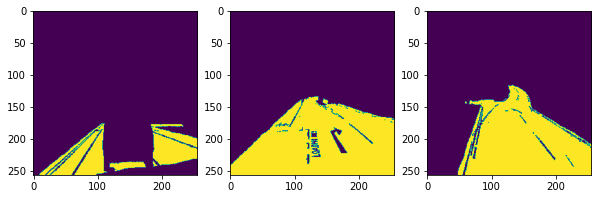

In [22]:
plt.figure(figsize=(10, 10))
for i,m in train_dataset.take(1):
    plt.subplot(1,3,1)
    plt.imshow(m[0])

for i,m in val_dataset.take(1):
    plt.subplot(1,3,2)
    plt.imshow(m[0])

for i,m in test_dataset.take(1):
    plt.subplot(1,3,3)
    plt.imshow(m[0])

**Witn augmentation function**

In [23]:
IM_SIZE = data_config["image_size"][0]


train_transforms = A.Compose(
    [
        A.Resize(IM_SIZE, IM_SIZE),
        A.OneOf([
            A.RandomSizedCrop(min_max_height=(250, 256), height=IM_SIZE, width=IM_SIZE, p=0.5),
            A.CenterCrop(height=IM_SIZE, width=IM_SIZE, p=0.5),
            A.PadIfNeeded(min_height=IM_SIZE, min_width=IM_SIZE, p=0.5)
            ], p=1),
        A.OneOf([
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5)]),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)
            ], p=0.8),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize(IM_SIZE, IM_SIZE),
      
    ]
)



In [24]:
tr_transforms_object = AlbumentatiosWrapper(train_transforms)
ts_transforms_object = AlbumentatiosWrapper(test_transforms)

# get datasets with augmentation

train_dataset = train_data_loader.load_data(transform_func=tr_transforms_object)
val_dataset = val_data_loader.load_data(transform_func=ts_transforms_object)
test_dataset = test_data_loader.load_data(transform_func=ts_transforms_object)

#### Make Model

In [25]:
print(model_config)
       

{'n_filters': [4, 8, 16, 32, 64], 'input_shape': [256, 256, 3], 'final_activation': 'sigmoid', 'activation': 'relu', 'backbone': 'resnet34', 'pretrained': True}


In [26]:
model_maker = Unet(**model_config)

In [27]:
model = Unet(**model_config).build_model()
#model.summary()

In [28]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=FocalTverskyLoss(alpha=0.5, gamma=0.5), metrics=[DiceScore()])

In [ ]:
model_history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1)